# Home Assignment 5

In [1]:
!pip3 list

Package                   Version
------------------------- ---------------
aiohttp                   3.9.3
aiosignal                 1.3.1
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bitarray                  2.9.2
bitcoinlib                0.6.14
bleach                    6.1.0
blockchain                1.4.4
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.1
cytoolz                   0.12.3
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
ecdsa                     0.18.0
enum-compat               0.0.3
eth-abi                   4.2.1
eth-account               0.11.0
eth-hash       

## Problem 1 (3 points). Shamir secret sharing

Find the secret and initial polynomial in (n, 4)-threshold Shamir secret sharing scheme over $F_{19}$ for $(3,17); (17,5); (5,11); (11,4)$. Is it consistnet with $(4, 3)$?

***Hint.*** *The whiteboard 16.2 contains an example.*

In [108]:
from sympy import *

def shamir_secret_sharing(points, prime_field):
    initial_polynomial = interpolate(points, 'x')
    coeffs = initial_polynomial.as_poly().coeffs()
    new_coeffs = []
    for coeff in coeffs:
        num = coeff.numerator % 19
        den = coeff.denominator % 19
        for i in range(1, 19):
            if (i * den) % 19 == 1:
                den = i
                break
        new_coeffs.append((num * den) % 19)

    x = symbols('x')
    polynom = Poly(new_coeffs, x).as_poly(domain=FF(19))
    secret = new_coeffs[3]
    return secret, polynom

In [109]:
points = [(3, 17), (17, 5), (5, 11), (11, 4)]
prime_field = 19

In [110]:
secret, polynomial = shamir_secret_sharing(points, prime_field)
print("Secret:", secret)
print("Initial Polynomial:", polynomial)

Secret: 1
Initial Polynomial: Poly(x**3 + 3*x**2 + 1, x, modulus=19)


In [111]:
polynomial(4)

-1

18 is more correct view

In [112]:
## Перепроверка
(4 ** 3 + 3 * 4 ** 2 + 1) % 19

18

18 != 3

(4,3) is not consistent

## Problem 2 (2* points). Schnorr ring signature

For the elliptic curve $y^2=x^3+7$ over $F_{127}$ and the hash function $H() = SHA256()\%127$. Consider a subgroup of point on a curve with a generator $G = (19, 32)$.

Suppose Alice has a private key $a = 17$ and Bob has a private key $b = 29$.

1. (0 points) Compute public keys.
2. (2* points) Generate Schnorr's ring signature for $m=77$ on Alice's behalf with $k=101$.

***Hint.*** *See "09.2 Privacy in Blockchains. Anonymization" for details.*

In [116]:
import hashlib

In [131]:
p = 127

In [125]:
def H(x):
    return int(hashlib.sha256(str(x).encode()).hexdigest(), 16) % p

In [126]:
def bits(n):
    while n:
        yield n & 1
        n >>= 1

def double_and_add(n, x):
    result = 0
    addend = x

    for bit in bits(n):
        if bit == 1:
            result += addend
        addend *= 2

    return result

In [127]:
private_key_Alice = 17
private_key_Bob = 29
m = 77
k = 101

In [138]:
x = double_and_add(private_key_Alice, 19)
y = double_and_add(private_key_Alice, 32)

public_key_Alice = (x % 127, y % 127)
print(public_key_Alice)

(69, 36)


In [129]:
x = double_and_add(private_key_Bob, 19)
y = double_and_add(private_key_Bob, 32)

public_key_Bob = (x % 127, y % 127)
print(public_key_Bob)

(43, 39)


In [134]:
x = double_and_add(int(str(m)+str(k)), 19)
y = double_and_add(int(str(m)+str(k)), 32)

e = (H(x), H(y))
e

(48, 104)

In [140]:
x_e, y_e = e
x_A, y_A = public_key_Alice

x = k - x_e * private_key_Alice
y = k - y_e * private_key_Alice

s = (x % 127, y % 127)
print(s)

(47, 111)


In [142]:
print(f"Signature: ({s}, {e})")

Signature: ((47, 111), (48, 104))


## Problem 3 (3 points). Bitcoin data

Consider tx=21e8fd77b81b6c4cf6723c10ea83acae77728f188ee6f4cd97ae114665b5fc0f (block height: 478994, tx index/position: 1603). Trace the transaction back to address 12t9YDPgwueZ9NyMgw519p7AA8isjr6SMw.

Use blockexplorer Python library, Bitcoin RPC or their equivalent alternative.

In [98]:
from blockchain import blockexplorer

tx_hash = '21e8fd77b81b6c4cf6723c10ea83acae77728f188ee6f4cd97ae114665b5fc0f'
target_address = '12t9YDPgwueZ9NyMgw519p7AA8isjr6SMw'

tx = blockexplorer.get_tx(tx_hash)
assert tx.block_height == 478994

In [106]:
def trace_transaction(tx_hash):
    tx = blockexplorer.get_tx(tx_hash)

    for input_ in tx.inputs:
        if input_.address == target_address:
            return tx
        else:
            prev_tx = blockexplorer.get_tx(str(input_.tx_index))
            prev_tx_hash = prev_tx.hash
            return trace_transaction(prev_tx_hash)

    return False

In [107]:
result = trace_transaction(tx_hash)      

In [108]:
print(blockexplorer.get_tx(str(result.tx_index)).hash)

409803bb5e124fd028c0482027c7722e84ce55b78204b279d3a44aba5e7c1698


The transaction with this hash '409803bb5e124fd028c0482027c7722e84ce55b78204b279d3a44aba5e7c1698' has target address in the inputs

## Problem 4 (3* points). Shared send untangling

1. (1* point) Simplify transaction (see Section 1 \[1\])
* 409803bb5e124fd028c0482027c7722e84ce55b78204b279d3a44aba5e7c1698
* 9ea6fdad2ea5870f5b17cb28587263f90cd7ec5c67f35d395a318186e5c79333
* c38aac9910f327700e0f199972eed8ea7c6b1920e965f9cb48a92973e7325046
* 659135664894e50040830edb516a76f704fd2be409ecd8d1ea9916c002ab28a2
2. (2* points) What are these transactions types (see Theorem 1)?

\[1\] https://bitfury.com/content/downloads/bitfury_whitepaper_shared_send_untangling_in_bitcoin_8_24_2016.pdf

## Problem 5 (4 points). ERC20 data

Consider (scam?) token 0xcae72a7a0fd9046cf6b165ca54c9e3a3872109e0 from Ethereum mainnet. How many tokens where transfered in Dec-2020?

https://etherscan.io/address/0xcae72a7a0fd9046cf6b165ca54c9e3a3872109e0

Let's turn to the etherscan website and evaluate the range of blocks that we need

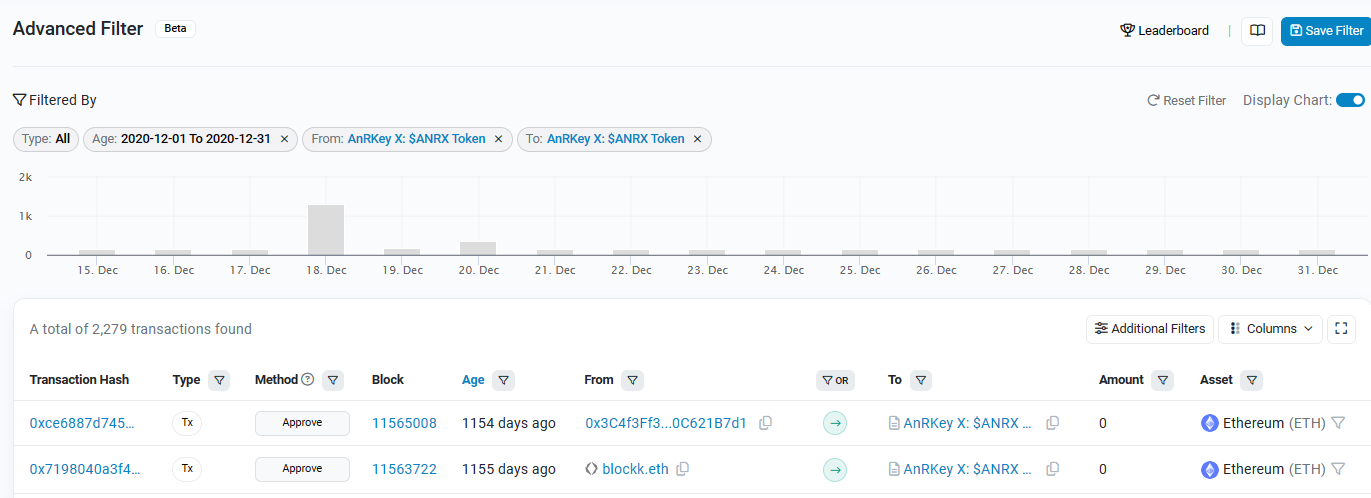

End block number = 11565008

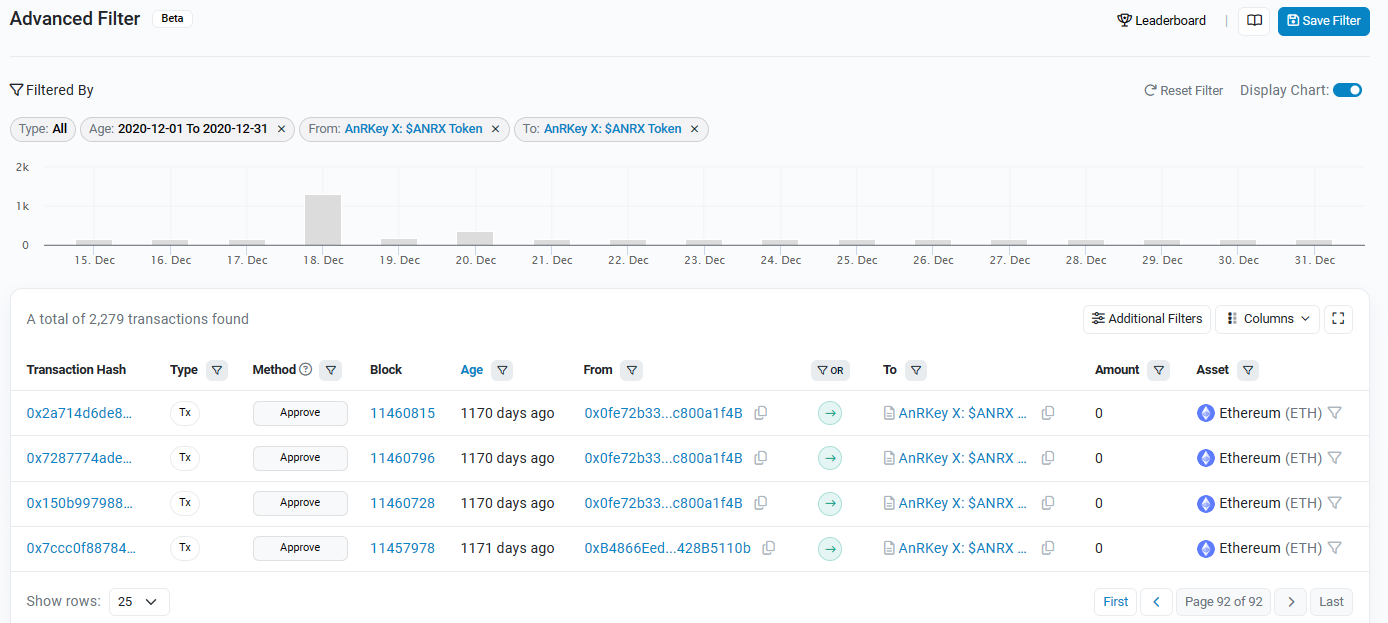

Start block number = 11457978

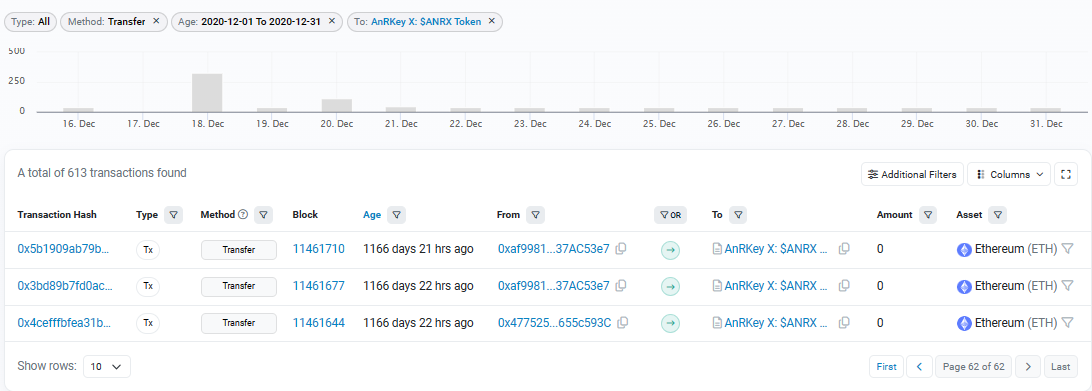

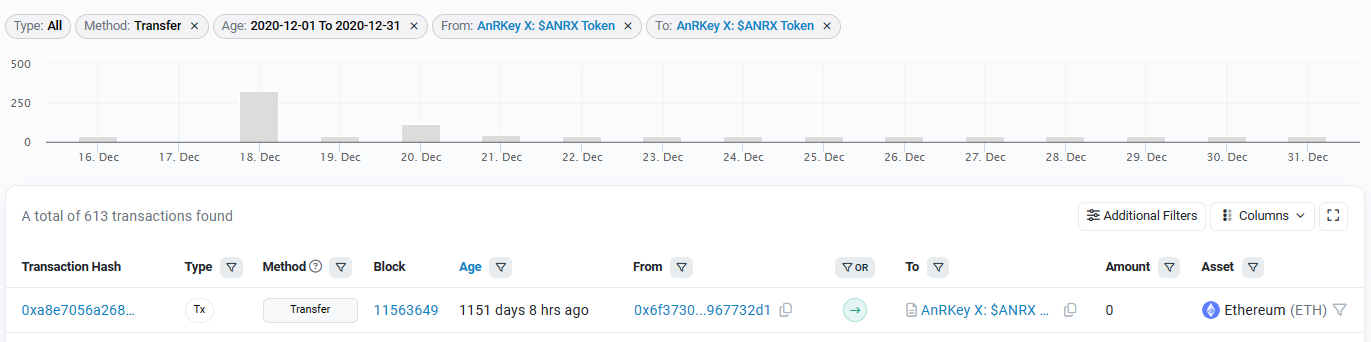

According to preliminary estimates, this number of blocks will be processed on my computer more than 5 hours

I thought it was too long and decided to save some time.

I uploaded the transactions in csv format and, using pandas, assembled an array with block numbers that contain the address of the contract

If necessary, I can separately upload the file that was uploaded from etherscan by this parameters

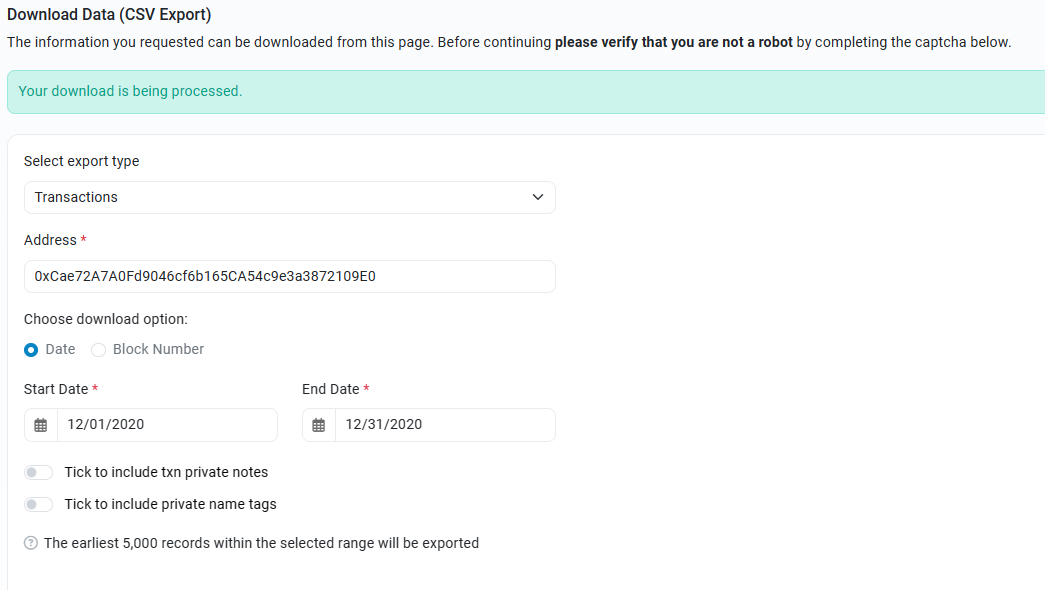

In [347]:
import pandas as pd

In [348]:
data = pd.read_csv('1.csv')

In [349]:
len(data)

2278

One transaction got lost because it has a different asset: 0xc2e4521f9a39009c3e19018c42d82c0241d18e9591e70915567a6077a40fb301

This time we will process it separately

In [350]:
blocks = list(data['Blockno'].unique())

In [351]:
len(blocks)

1736

In [352]:
print(blocks, sep=' ')

[11457978, 11460728, 11460796, 11460815, 11461644, 11461677, 11461710, 11461718, 11461758, 11461765, 11461768, 11470273, 11470344, 11470503, 11471428, 11474463, 11474475, 11474508, 11474859, 11475032, 11475083, 11475424, 11475497, 11475722, 11475870, 11475897, 11475915, 11475937, 11475983, 11476007, 11476033, 11476143, 11476193, 11476213, 11476244, 11476271, 11476278, 11476281, 11476296, 11476319, 11476352, 11476360, 11476368, 11476395, 11476444, 11476448, 11476454, 11476455, 11476456, 11476457, 11476458, 11476459, 11476460, 11476461, 11476462, 11476463, 11476464, 11476465, 11476466, 11476467, 11476468, 11476469, 11476471, 11476472, 11476473, 11476474, 11476475, 11476476, 11476478, 11476480, 11476481, 11476482, 11476483, 11476484, 11476485, 11476489, 11476490, 11476491, 11476492, 11476493, 11476495, 11476496, 11476497, 11476499, 11476501, 11476502, 11476503, 11476504, 11476505, 11476506, 11476507, 11476508, 11476509, 11476510, 11476511, 11476512, 11476513, 11476514, 11476515, 11476516,

We can process 1736 much faster!

In [143]:
import pickle
from tqdm import tqdm
from web3_input_decoder import decode_constructor, decode_function
from web3 import Web3
import requests, json

In [144]:
abi = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"burn","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"subtractedValue","type":"uint256"}],"name":"decreaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"addedValue","type":"uint256"}],"name":"increaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"isOwner","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"mint","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"renounceOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"sender","type":"address"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"}]'

In [145]:
provider = Web3.HTTPProvider('https://eth-mainnet.g.alchemy.com/v2/TMBtSkKRFGP3C2IL4mckTgJ5R24rL7X9')
web3 = Web3(provider)

address = '0xCae72A7A0Fd9046cf6b165CA54c9e3a3872109E0'
contract = web3.eth.contract(address=address, abi=abi)

start = 11461644
end = 11563649

In [360]:
tx_dict = {}

for x in tqdm(blocks):
    block = web3.eth.get_block(int(x), True)
    for transaction in block.transactions:
        if transaction['to'] == address or transaction['from'] == address:
            with open("transactions.pkl", "wb") as f:
                hashStr = transaction['hash'].hex()
                tx_dict[hashStr] = transaction
                pickle.dump(tx_dict, f)
            f.close()

100%|██████████████████████████████████████████████████████████████████████████████| 1736/1736 [21:13<00:00,  1.36it/s]


In [147]:
len(tx_dict)

2278

Approval

In [157]:
tx = tx_dict['0x7ccc0f887845141a13bad9d215e8168076505d5b1f94f6be03d3025cc8b82719']

In [154]:
decode_function(json.loads(abi), tx['input'])

[('address', 'spender', '0x7a250d5630b4cf539739df2c5dacb4c659f2488d'),
 ('uint256',
  'amount',
  115792089237316195423570985008687907853269984665640564039457584007913129639935)]

Transfer

In [155]:
tx = tx_dict['0xa8e7056a26899c372387f356788fe33eabbe88daabd2d981b5c95668e12a5b49']

In [156]:
decode_function(json.loads(abi), tx['input'])

[('address', 'recipient', '0x7b5052f08a0285345759c59e973102cba2c993aa'),
 ('uint256', 'amount', 69504506372589899658015)]

Approval

In [160]:
tx = tx_dict['0x0882a9495f9e5717e2e2c05ed59de7064594d3421968f4667bc3a47d79609b5d']

In [161]:
decode_function(json.loads(abi), tx['input'])

[('address', 'spender', '0x7a250d5630b4cf539739df2c5dacb4c659f2488d'),
 ('uint256',
  'amount',
  115792089237316195423570985008687907853269984665640564039457584007913129639935)]

Transfer

In [176]:
tx = tx_dict['0xb93ff67582773a04503f1a79a07774029fd0226e5f7f93b06f401bdf57e3f4a7']

In [177]:
decode_function(json.loads(abi), tx['input'])

[('address', 'recipient', '0xce8baa66670163b990687ce62aed73552aa112a3'),
 ('uint256', 'amount', 15888000000000000000000)]

In [181]:
count = 0
sum = 0
for hash in tx_dict.keys():
    tx = tx_dict[hash]
    if tx['input'].hex() == '0x':
        continue
    
    decoded = decode_function(json.loads(abi), tx['input'])
    _, rec, _ = decoded[0]
    _, _, amount = decoded[1]
    
    if rec == 'recipient':
        sum += int(amount)
        count += 1

print(f'How many: {sum} in {count} transactions')

How many: 42321877889967853767597355 in 612 transactions


In [ ]:
42321877889967853767597355

## Problem 6 (3* points). BigQuery

Consider (scam?) token 0xcae72a7a0fd9046cf6b165ca54c9e3a3872109e0 from Ethereum mainnet. Compute the total amount of tokens transfered. Use bigquery-public-data.crypto_ethereum (https://ethereum-etl.readthedocs.io/en/latest/google-bigquery/).

***Warning!*** *You need both a VPN and a foreign bank card to set up BigQuery.*